# Weather Model

#### Aim : To generate weather data for cities in given format

#### Plan : 

- Fetch the consolidated data from weather website for past few months (done using data_provider.py script)
- Transform the data and selected relevant features
- Since each city has different weather conditions, make a classifier for each city and
  use to predict the condition of the weather based on Temperature, Pressure and Humidity
- To generate the data:
    - Plan A:
        Either Use covariance amongst all the features and generate random data closely related to each other
    - Plan B:
        Use some other months data to provide feature and use our classifier to classify it.


In [1]:
import numpy as np
import pandas as pd
from pprint import pprint as pp
import json, os, sys, random, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
random.seed(0)
from time import sleep
%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


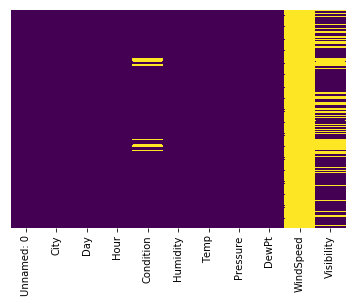

In [2]:
GEOGRAPHICAL_DATA = { 
'Sydney': [-33.86,151.20,19],
'Melbourne': [-37.66,144.84,124],
'Brisbane': [-27.47,153.02,28],
'Gold_Coast': [-28.01,153.42,3.9],
'Adelaide': [-34.92,138.59,44.7],
'Darwin': [-12.46,130.84,37],
'Wollongong': [-34.42,150.89,19],
'Canberra': [-35.28,149.12,576.7],
'Newcastle': [-32.92,151.77,12.81],
'Hobart': [-42.83,147.50,6]
}

# load data 
df = pd.read_csv('../training_data/input_data_201710.csv')
# check for nulls
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Transform

In [3]:
# cleanup and format data


# remove last two features with so many nulls
df = df.iloc[:,1:-2]

# drop rows with nulls
df = df.dropna(axis=0,how='any')

# change the datatype
df[['Day','Hour','Humidity']] = df[['Day','Hour','Humidity']].astype(int)
df[['Temp','DewPt','Pressure']] = df[['Temp','DewPt','Pressure']].astype(float)

# rename column
df.rename(columns={'City': 'Location','Day':'Date'}, inplace=True)

# insert position columns for cities
df.insert(1, 'Position', '')

# populate data in the position coloumn 
df['Position'] = [GEOGRAPHICAL_DATA[city]  for city in df['Location']]

# simplify the weathers to rain, cloudy, and clear

weather_conditions= { 
    'Rain' : ['Light Rain',
              'Light Rain Showers',
              'Light Drizzle',
              'Light Thunderstorms and Rain',
              'Heavy Rain Showers',
              'Unknown Precipitation',
              'Thunderstorms and Rain',
              'Rain',
              'Rain Showers',
              'Thunderstorm',
              'Heavy Thunderstorms and Rain',
              'Heavy Rain',
              'Drizzle',
              'Heavy Drizzle'],
    'Cloudy':['Mostly Cloudy',
              'Partly Cloudy',
              'Overcast',
              'Scattered Clouds'
             ],
    'Clear':['Clear'],
    'Snow':['Snow']
}

def simplify(cond):
    if cond in weather_conditions['Rain']:
        cond = 'Snow'
    elif cond in weather_conditions['Clear']:
        cond = 'Sunny'
    elif cond in weather_conditions['Snow']:
        cond = 'Snow'
    elif cond in weather_conditions['Cloudy']:
        cond = 'Rain'
    else:
        cond = 'Sunny'
    return cond

df['Condition'] = df['Condition'].apply(simplify)
df = df[df['Condition'] != 'Unknown']

# rearrange the columns
df = df[['Date','Hour','Location','Position','Condition','Temp','Pressure','Humidity','DewPt']]

# sort by location,data and hour
df = df.sort_values(['Location','Date','Hour'])

#generate LocalTime Column from day and hour
tmp = pd.DataFrame(
{
    'Time':['{:02}:{:02}:{:02}'.format(hr,random.randint(0,60),random.randint(0,60)) for hr in df['Hour'] ],
    'Date':['2017-11-{:02}'.format(day) for day in df['Date']]
})

df.insert(4,'LocalTime','')
df['LocalTime'] = tmp['Date'] + ' ' + tmp['Time']


# To feed sklearn I have to convert the 'conditions' text data to a numeric value
labels = {}

for label, condition in enumerate( df['Condition'].unique() ):
    labels[condition] = label

df['label'] = df['Condition'].apply(lambda c: labels.get(c))

# handy map to refer back to the condition
label_map = { v:k for k,v in labels.items() }



### Analysis of features

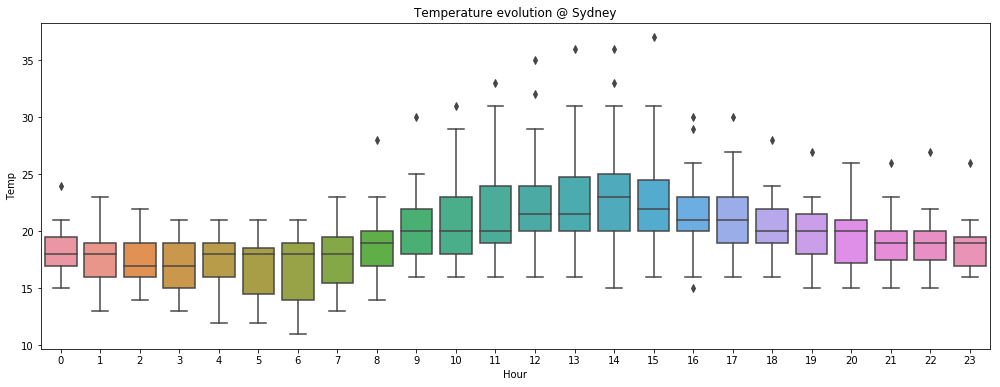

In [4]:
# variation/range of temp in syndey each hour during the day

idx = (df['Location'] == 'Sydney')
plt.figure(figsize=[17,6])
sns.boxplot(data=df[idx], x='Hour', y='Temp')
plt.title('Temperature evolution @ Sydney')
plt.show()


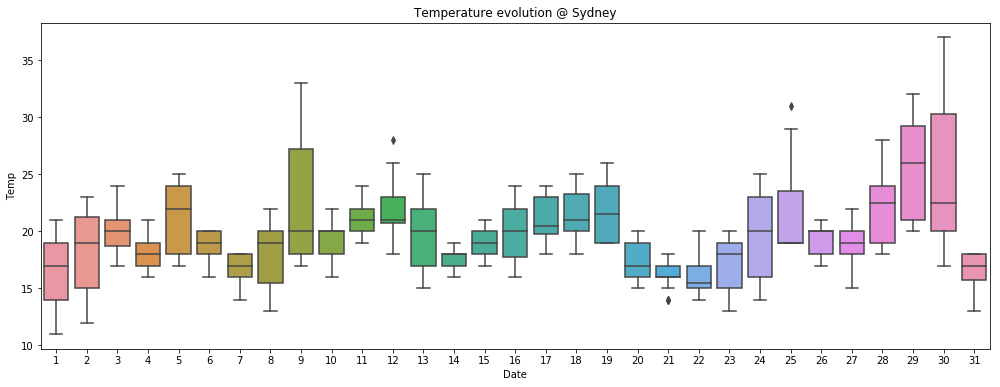

In [5]:
# variation/range of temp in syndey during the month
idx = (df['Location'] == 'Sydney')
plt.figure(figsize=[17,6])
sns.boxplot(data=df[idx], x='Date', y='Temp')
plt.title('Temperature evolution @ Sydney')
plt.show()

### Relation of Temperature with other features

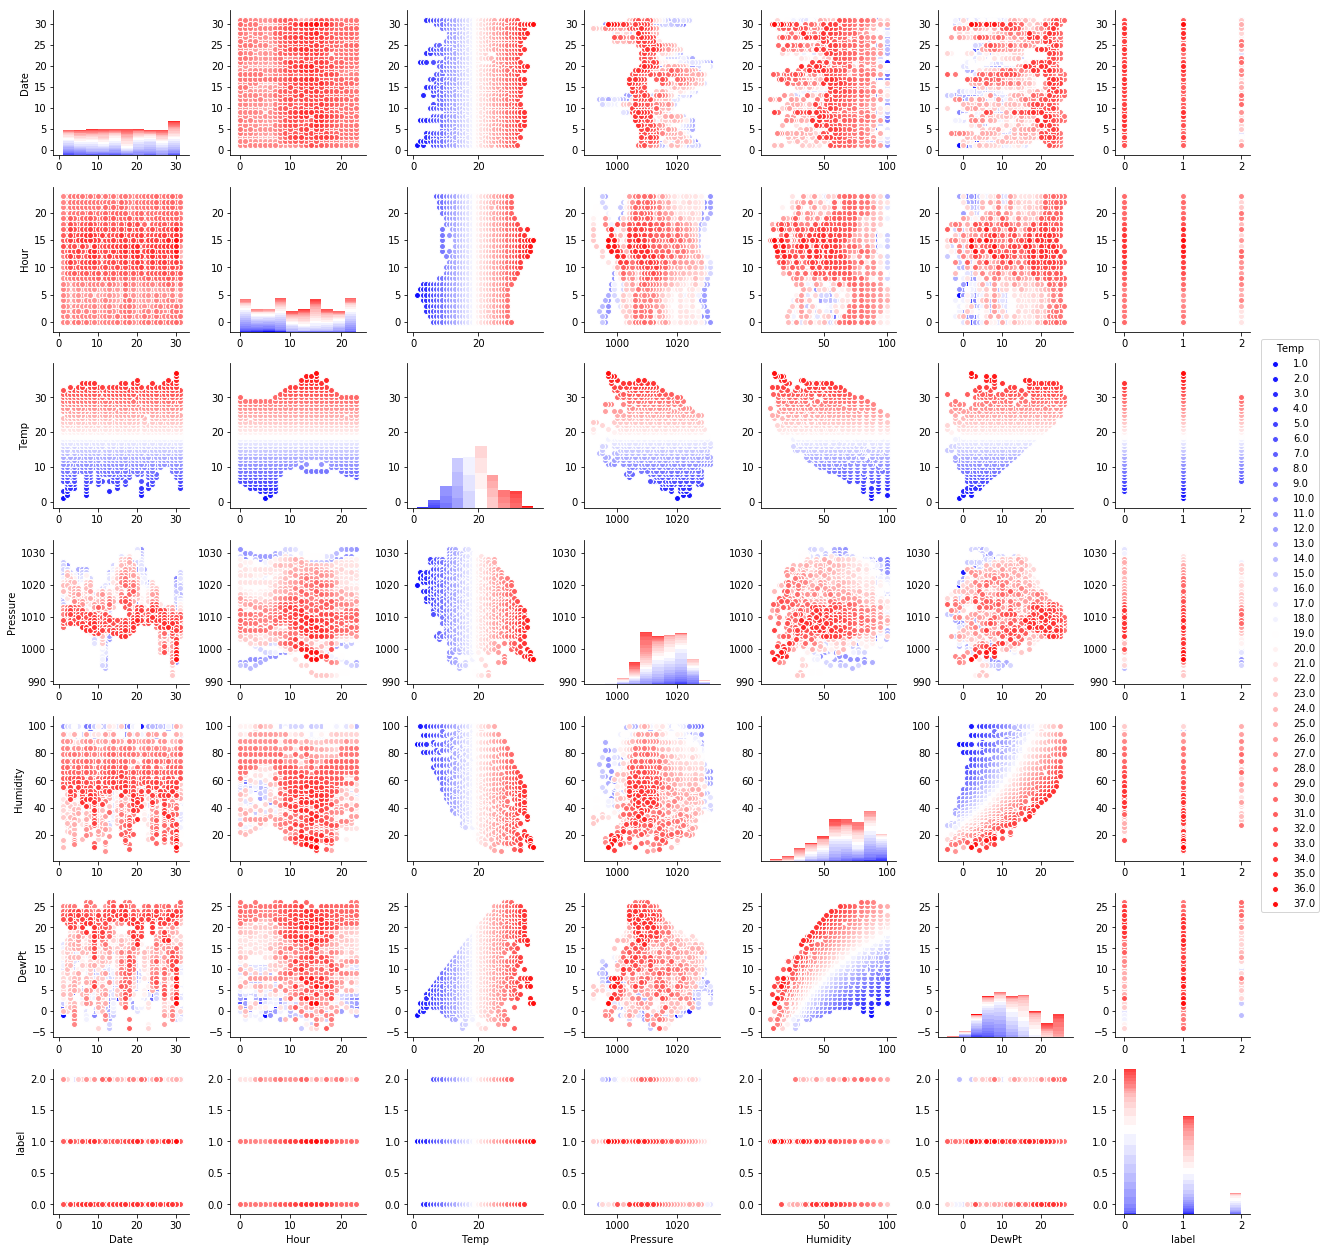

In [6]:
sns.pairplot(data=df, hue='Temp', palette='bwr')

### Relation of Pressure with other features

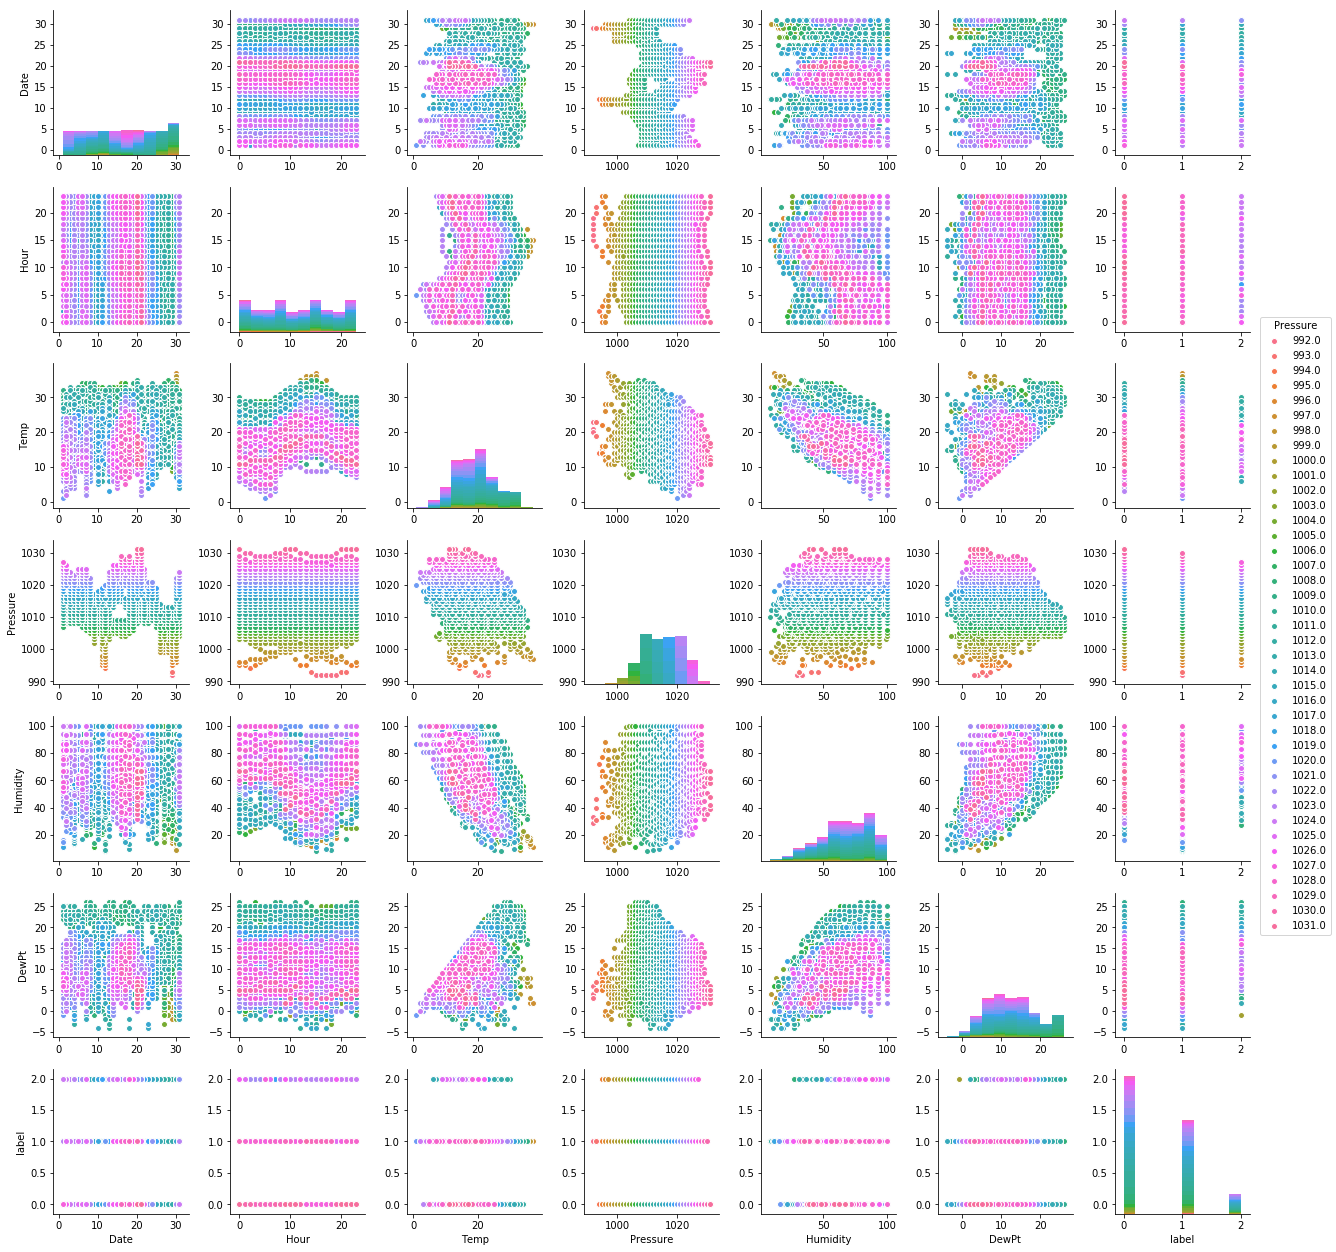

In [7]:
sns.pairplot(data=df, hue='Pressure')

### Building Classifiers

In [8]:
# Learning algorithm 
def learn(trainingData, features_to_drop):


    # trainingY = pd.get_dummies(trainingData['Condition'], 'Condition')
    trainingY = trainingData['label']

    trainingData.drop(features_to_drop, axis=1, inplace=True)

    # Split my data into train and test to avoid overfiting
    X_train, X_test, Y_train, Y_test = train_test_split(trainingData, trainingY)

    #  I will train a Support Vector Machine classifier
    #     note: I tried with a Logistic Regression but I only got 68% accuracy

    classifier = SVC()
    # classifier = SVC(kernel='rbf', verbose=True)
#     classifier = SVC(kernel='poly',degree=2)
    # classifier = LogisticRegression(C=1e5)
    # classifier = KNeighborsClassifier()
    classifier.fit(X=X_train, y=Y_train)

    # Now I'll check the accuracy of my model
    train_ac = classifier.score(X=X_train, y=Y_train)
    test_ac = classifier.score(X=X_test, y=Y_test)
    print('Training accuracy: {}   -  Testing accuracy: {} '.format(train_ac,test_ac))
    
    return classifier


In [9]:
# data set with all features
df.head()

,Date,Hour,Location,Position,LocalTime,Condition,Temp,Pressure,Humidity,DewPt,label
2465,1,0,Adelaide,"[-34.92, 138.59, 44.7]",2017-11-06 16:11:43,Rain,10.0,1026.0,87,8.0,0
2466,1,1,Adelaide,"[-34.92, 138.59, 44.7]",2017-11-06 17:53:22,Rain,9.0,1026.0,82,6.0,0
2467,1,3,Adelaide,"[-34.92, 138.59, 44.7]",2017-11-06 18:27:54,Rain,8.0,1025.0,87,6.0,0
2468,1,4,Adelaide,"[-34.92, 138.59, 44.7]",2017-11-06 19:27:26,Rain,8.0,1025.0,87,6.0,0
2469,1,5,Adelaide,"[-34.92, 138.59, 44.7]",2017-11-06 20:23:37,Rain,8.0,1025.0,81,5.0,0


In [10]:
# Drop unnecessary features
features_to_drop = ['Location','Position','LocalTime','Condition','DewPt','label']


In [11]:
# create a predictor for each city and maintain in a dict to use it later for generating data
city_predictor = { }
city_stats_meta = {}
print('''####################  Building Classifiers for each City #################### \n \n Accuracy level: \n''')
for city in df['Location'].unique():
    trainingData = df[ df['Location'] == city ].copy()
    
    print('City: {} '.format(city))
    classifier = learn(trainingData,features_to_drop)
    city_predictor.update({city:classifier})
 
    statistics = trainingData.describe()
    mean = [
        statistics['Pressure']['mean'],
        statistics['Temp']['mean'],
        statistics['Humidity']['mean']]
    
    covariance = statistics[['Temp','Pressure','Humidity']].cov()
    city_stats_meta.update({city:[mean,covariance]})




####################  Building Classifiers for each City #################### 
 
 Accuracy level: 

City: Adelaide 
Training accuracy: 0.9891304347826086   -  Testing accuracy: 0.7717391304347826 
City: Brisbane 
Training accuracy: 1.0   -  Testing accuracy: 0.6785714285714286 
City: Canberra 
Training accuracy: 0.9856373429084381   -  Testing accuracy: 0.6612903225806451 
City: Darwin 
Training accuracy: 0.9261261261261261   -  Testing accuracy: 0.6648648648648648 
City: Gold_Coast 
Training accuracy: 0.9695340501792115   -  Testing accuracy: 0.7043010752688172 
City: Hobart 
Training accuracy: 0.9784172661870504   -  Testing accuracy: 0.7419354838709677 
City: Melbourne 
Training accuracy: 0.9873873873873874   -  Testing accuracy: 0.6989247311827957 
City: Newcastle 
Training accuracy: 0.972972972972973   -  Testing accuracy: 0.6720430107526881 
City: Sydney 
Training accuracy: 0.9782214156079855   -  Testing accuracy: 0.7445652173913043 
City: Wollongong 
Training accuracy: 1.0   - 

In [12]:
# Sample prediction
predicted_value = city_predictor['Adelaide'].predict([[0,0,0,0,0]])[0]
label_map[predicted_value]

'Rain'

# Selected Features for analysis

In [13]:
# for checking purpose only
check = df.copy()
check.drop(features_to_drop, axis=1, inplace=True)
# dataset with selected features
check.head()

,Date,Hour,Temp,Pressure,Humidity
2465,1,0,10.0,1026.0,87
2466,1,1,9.0,1026.0,82
2467,1,3,8.0,1025.0,87
2468,1,4,8.0,1025.0,87
2469,1,5,8.0,1025.0,81


#### Build a weather generator using, randomly generating features from multivariance amongst features
#### and use the result to test the classifiers

In [14]:


weather_generator = np.random.multivariate_normal    

city_list = list(GEOGRAPHICAL_DATA.keys())

for each in range(1,5):
    city = np.random.choice(city_list)
    generated_values = weather_generator(*city_stats_meta[city]).tolist()
    day,hour = datetime.datetime.now().day, datetime.datetime.now().hour 
    temp, pressure, humidity = list(generated_values)
    generated_values = [day,hour]+generated_values
    predicted_value = city_predictor[city].predict([generated_values])[0]
    condition = label_map[predicted_value]
    output_dict = {
        'city':city,
        'condition':condition,
        'temp':temp,
        'pressure':pressure,
        'humidity':humidity,
        'day':day,
        'hour':hour
    }
    output_string = '''  For {city} Params: day-{day},hour-{hour},temp- +{temp:.01f},pressure-{pressure:.01f},humidity-{humidity:.0f}\n
    Predicted Condition is : {condition} \n'''.format(**output_dict)
    sleep(0.2)
    print(output_string)


  For Melbourne Params: day-11,hour-1,temp- +1117.8,pressure-375.3,humidity-179

    Predicted Condition is : Rain 

  For Darwin Params: day-11,hour-1,temp- +932.4,pressure--39.0,humidity--43

    Predicted Condition is : Rain 

  For Canberra Params: day-11,hour-1,temp- +1081.8,pressure--255.8,humidity-111

    Predicted Condition is : Rain 

  For Gold_Coast Params: day-11,hour-1,temp- +1416.6,pressure--132.4,humidity-455

    Predicted Condition is : Rain 



### The Classifiers are working 

##### But generated values are not reliable, therefore I will be to using next months data to generate the weather
### Loading next months data

In [15]:
# Quick Clean up and transforming data to just relevant features.
ds = pd.read_csv('../training_data/input_data_201711.csv')
ds = ds[['City','Day','Hour','Temp','Pressure','Humidity']]
ds = ds.iloc[:,0:8].dropna(axis=0,how='any')
ds = ds.sample(frac=1).reset_index(drop=True)
ds = ds.sort_values(['Day','Hour'])
ds.head()

,City,Day,Hour,Temp,Pressure,Humidity
89,Sydney,10,0,17.0,1027,68
107,Hobart,10,0,12.0,1029,72
223,Gold_Coast,10,0,16.0,1023,94
447,Brisbane,10,0,16.0,1024,86
499,Darwin,10,0,28.0,1008,79


### Generating the Weather String

In [16]:

for i in range(0,ds.count()[0]-1):
    row = ds.iloc[i]
    
    city,day,hour,temp, pressure, humidity = row
    predicted_value = city_predictor[city].predict([ row[1:] ])[0]
    condition = label_map[ predicted_value ]
    
    time = '{:02}:{:02}:{:02}'.format(hour,random.randint(0,60),random.randint(0,60))
    date = '2017-11-{:02}'.format(day)
    localtime = time + 'T' + date + 'Z'
    position = GEOGRAPHICAL_DATA[city]

    output_dict = {
    'city':city,
    'lat':position[0],
    'long':position[1],
    'elevation':position[2],
    'localtime':localtime,
    'condition':condition,
    'temp':temp,
    'pressure':pressure,
    'humidity':humidity
    }
    output_string = '''{city}|{lat},{long},{elevation}|{localtime}|'''.format(**output_dict)
    output_string += '''{condition}|+{temp:.01f}|{pressure:.01f}|{humidity:.0f}'''.format(**output_dict)
    sleep(0.2)
    print(output_string)
    if i>10:
        break 

Sydney|-33.86,151.2,19|00:02:04T2017-11-10Z|Rain|+17.0|1027.0|68
Hobart|-42.83,147.5,6|00:38:41T2017-11-10Z|Rain|+12.0|1029.0|72
Gold_Coast|-28.01,153.42,3.9|00:46:02T2017-11-10Z|Rain|+16.0|1023.0|94
Brisbane|-27.47,153.02,28|00:50:22T2017-11-10Z|Rain|+16.0|1024.0|86
Darwin|-12.46,130.84,37|00:52:35T2017-11-10Z|Rain|+28.0|1008.0|79
Wollongong|-34.42,150.89,19|00:58:30T2017-11-10Z|Sunny|+11.0|1028.0|78
Melbourne|-37.66,144.84,124|00:54:27T2017-11-10Z|Rain|+11.0|1026.0|94
Newcastle|-32.92,151.77,12.81|00:52:59T2017-11-10Z|Rain|+13.0|1027.0|82
Canberra|-35.28,149.12,576.7|00:36:56T2017-11-10Z|Rain|+8.0|1028.0|71
Adelaide|-34.92,138.59,44.7|00:40:56T2017-11-10Z|Rain|+23.0|1019.0|27
Darwin|-12.46,130.84,37|01:31:49T2017-11-10Z|Rain|+27.0|1007.0|84
Wollongong|-34.42,150.89,19|01:07:12T2017-11-10Z|Sunny|+11.0|1028.0|87


## Thank You